In [ ]:
'''

# Diffusion 2D - inbuilt 
#Testing out various NPDE kinks on the 2D diffusion problem 
# u_t = D(u_xx + u_yy)
# With Dirichlet Boundary Conditions equal to zero
# Data built from the in-built Diffusion Solver in the py-pde package

import numpy as np
!pip install py-pde
from pde import DiffusionPDE, ScalarField, UnitGrid, PlotTracker, MemoryStorage, CartesianGrid

grid_length = 64
grid = UnitGrid([grid_length, grid_length])  # generate grid
state = ScalarField.random_normal(grid, mean=0.5, seed=42)  # generate initial condition
state.data = np.exp(-40*((np.linspace(0,1,64)-0.5)**2 + (np.linspace(0,1,64)-0.5)**2))
bc_x = {"value": 0.0}
bc_y = {"value": 0.0}

bc = [bc_x, bc_y]


eq = DiffusionPDE(diffusivity=5.0,  bc=bc)  # define the pde
tracker = PlotTracker(interval=0.1)
storage = MemoryStorage()
result = eq.solve(state, t_range=1.0, tracker=[tracker, storage.tracker(0.1)])

initial = state.data
final = result.data

u = storage.data

'''

'\n\n# Diffusion 2D - inbuilt \n#Testing out various NPDE kinks on the 2D diffusion problem \n# u_t = D(u_xx + u_yy)\n# With Dirichlet Boundary Conditions equal to zero\n# Data built from the in-built Diffusion Solver in the py-pde package\n\nimport numpy as np\n!pip install py-pde\nfrom pde import DiffusionPDE, ScalarField, UnitGrid, PlotTracker, MemoryStorage, CartesianGrid\n\ngrid_length = 64\ngrid = UnitGrid([grid_length, grid_length])  # generate grid\nstate = ScalarField.random_normal(grid, mean=0.5, seed=42)  # generate initial condition\nstate.data = np.exp(-40*((np.linspace(0,1,64)-0.5)**2 + (np.linspace(0,1,64)-0.5)**2))\nbc_x = {"value": 0.0}\nbc_y = {"value": 0.0}\n\nbc = [bc_x, bc_y]\n\n\neq = DiffusionPDE(diffusivity=5.0,  bc=bc)  # define the pde\ntracker = PlotTracker(interval=0.1)\nstorage = MemoryStorage()\nresult = eq.solve(state, t_range=1.0, tracker=[tracker, storage.tracker(0.1)])\n\ninitial = state.data\nfinal = result.data\n\nu = storage.data\n\n'

# Diffusion 2D
Numerical Method - Spectral Solver using FFT. <br>
Code taken from [this tutorial](http://people.bu.edu/andasari/courses/numericalpython/Week11Lecture19/PythonFiles/adi_2d_oop.py). <br>
```
u_t = D*(u_xx + u_yy) on [-1,1] x [-1,1] 
```

Neumann Boundary Conditions : 
```
u_x = u_y =0
```

Initial Distribution :
```
 u(x,y,t=0) = Centre concentration
 ```

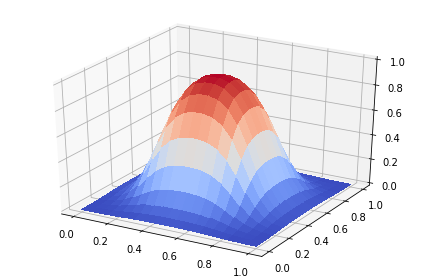

In [ ]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

class ADImethod:
    
    def __init__(self, M, maxt, D):
        self.M = M
        self.x0 = 0
        self.xf = 1
        self.y0 = 0
        self.yf = 1
        self.maxt = maxt
        self.dt = 0.01
        self.D = D
        self.h = 1/self.M
        self.r = self.D*self.dt/(2*self.h**2)
        self.generateGrid()
        self.lhsMatrixA()
        self.rhsMatrixA()

        self.x = np.linspace(self.x0, self.xf, self.M)
        self.y = np.linspace(self.y0, self.yf, self.M)
        # self.t = np.arange(0, self.maxt + self.dt, self.dt)
            
    def generateGrid(self):
        self.X, self.Y = np.meshgrid(np.linspace(self.x0, self.xf, self.M), np.linspace(self.y0, self.yf,self. M))
        ic01 = np.logical_and(self.X >= 1/4, self.X <= 3/4)
        ic02 = np.logical_and(self.Y >= 1/4, self.Y <= 3/4)
        ic0 = np.multiply(ic01, ic02)
        self.U = ic0*1

    
    def lhsMatrixA(self):
        maindiag = (1+2*self.r)*np.ones((1, self.M))
        offdiag = -self.r*np.ones((1, self.M-1))
        a = maindiag.shape[1]
        diagonals = [maindiag, offdiag, offdiag]
        Lx = sparse.diags(diagonals, [0, -1, 1], shape=(a, a)).toarray()
        Ix = sparse.identity(self.M).toarray()
        self.A = sparse.kron(Ix, Lx).toarray()
        
        pos1 = np.arange(0,self.M**2,self.M)
        
        for i in range(len(pos1)):
            self.A[pos1[i], pos1[i]] = 1 + self.r
            
        pos2 = np.arange(self.M-1, self.M**2, self.M)
        
        for j in range(len(pos2)):
            self.A[pos2[j], pos2[j]] = 1 + self.r
        
    
    def rhsMatrixA(self):
        maindiag = (1-self.r)*np.ones((1, self.M))
        offdiag = self.r*np.ones((1, self.M-1))
        a = maindiag.shape[1]
        diagonals = [maindiag, offdiag, offdiag]
        Rx = sparse.diags(diagonals, [0, -1, 1], shape=(a, a)).toarray()
        Ix = sparse.identity(self.M).toarray()
        self.A_rhs = sparse.kron(Rx, Ix).toarray()
        
        pos3 = np.arange(self.M, self.M**2-self.M)
        
        for k in range(len(pos3)):
            self.A_rhs[pos3[k], pos3[k]] = 1 - 2*self.r
            
            
    def solve_and_plot(self):
        u_list = []
        u_list.append(self.U)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.set_zlim(0, 1)
        tc = 0
        nstep = round(self.maxt/self.h)

        t = np.linspace(0, self.maxt, nstep+1)

        while tc < nstep:
            b1 = np.flipud(self.U).reshape(self.M**2, 1)
            sol = np.linalg.solve(self.A, np.matmul(self.A_rhs, b1))
            self.U = np.flipud(sol).reshape(self.M, self.M)
            
            b2 = np.flipud(self.U).reshape(self.M**2, 1)
            sol = np.linalg.solve(self.A, np.matmul(self.A_rhs, b2))
            self.U = np.flipud(sol).reshape(self.M, self.M)
            tc += 1
            u_list.append(self.U)
        ax.plot_surface(self.X, self.Y, self.U, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
        plt.tight_layout()
        plt.show()
        return self.x, self.y, t, np.asarray(u_list)
    


if __name__ == "__main__":
    grid_length = 20
    time = 2.5
    D = 0.01

    simulator = ADImethod(grid_length, time, D)
    x, y, t, u = simulator.solve_and_plot()

    

In [ ]:
len(t)

51

In [ ]:
import os
import time
from tqdm import tqdm 
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
%matplotlib inline


!pip install pyDOE
from pyDOE import lhs
import torch
import torch.nn as nn

# %
default_device = "cuda" if torch.cuda.is_available() else "cpu"

dtype=torch.float32
torch.set_default_dtype(dtype)

def torch_tensor_grad(x, device):
    if device == 'cuda':
        x = torch.cuda.FloatTensor(x)
    else:
        x = torch.FloatTensor(x)
    x.requires_grad = True
    return x 

def torch_tensor_nograd(x, device):
    if device == 'cuda':
        x = torch.cuda.FloatTensor(x)
    else:
        x = torch.FloatTensor(x)
    x.requires_grad = False
    return x 

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp37-none-any.whl size=18178 sha256=37ffa626c6a311698bd82dcc90aadf175cb20365ed166a80cfb8989fbdf8dacd
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


In [ ]:
# Setting the random seed. 
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
#Setting up a Resnet as the PINN. 
class Resnet(nn.Module):
    def __init__(self, in_features, out_features, num_neurons, activation=torch.sin):
        super(Resnet, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.num_neurons = num_neurons
        
        self.act_func = activation
        
        self.block1_layer1 = nn.Linear(self.in_features, self.num_neurons)
        self.block1_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        self.block1 = [self.block1_layer1, self.block1_layer2]
        
        self.block2_layer1 = nn.Linear(self.in_features + self.num_neurons, self.num_neurons)
        self.block2_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        self.block2 = [self.block2_layer1, self.block2_layer2]
        
        self.block3_layer1 = nn.Linear(self.in_features + self.num_neurons, self.num_neurons)
        self.block3_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        self.block3 = [self.block3_layer1, self.block3_layer2]
        
        self.block4_layer1 = nn.Linear(self.in_features + self.num_neurons, self.num_neurons)
        self.block4_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        self.block4 = [self.block4_layer1, self.block4_layer2]
        
        self.layer_after_block = nn.Linear(self.num_neurons + self.in_features, self.num_neurons)
        self.layer_output = nn.Linear(self.num_neurons, self.out_features)
        
        
    def forward(self, x):
        
        x_temp = x
        
        for dense in self.block1:
            x_temp = self.act_func(dense(x_temp))
        x_temp = torch.cat([x_temp, x], dim=-1)
        
        for dense in self.block2:
            x_temp = self.act_func(dense(x_temp))
        x_temp = torch.cat([x_temp, x], dim=-1)
        
        for dense in self.block3:
           x_temp = self.act_func(dense(x_temp))           
        x_temp = torch.cat([x_temp, x], dim=-1)
        
        for dense in self.block4:
           x_temp = self.act_func(dense(x_temp))
        x_temp = torch.cat([x_temp, x], dim=-1)
        
        x_temp = self.act_func(self.layer_after_block(x_temp))
        x_temp = self.layer_output(x_temp)
        return x_temp

#Setting up a derivative function that goes through the graph and calculates via chain rule the derivative of u wrt x 
deriv = lambda u, x: torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]


In [ ]:
#Setting up an instance of the Resnet with the needed architecture. 
npde_net = Resnet(3, 1, 100)
npde_net = npde_net.to(default_device)


In [ ]:
from pyDOE import lhs

#Specifying the Domain of Interest. 
x_range = [0.0, 1.0]
y_range = [0.0, 1.0]
t_range = [0.0, 2.5]
D = 0.01

lb = np.asarray([x_range[0], y_range[0], t_range[0]])
ub = np.asarray([x_range[1], y_range[1], t_range[1]])

def LHS_Sampling(N):
    return lb + (ub-lb)*lhs(3, N)


The combined formulation : 

```
def pde(X):
    u = npde_net(X)
    u_X = deriv(u, X)
    u_XX = deriv(u_X, X)
    pde_loss = u_X[:,2:3] - D*(u_XX[:,0:1] + u_XX[:,1:2])


    return pde_loss.pow(2).mean()

```
is not represenative of the wave equation as the jacobian vector product over the first order gradients includes a sum over the derivatives of all input parameters. 

what we see as:
```
u_xx = u_xx + u_yx + u_zx 
u_yy = u_xy + u_yy + u_zy
u_zz = u_xz + u_yz + u_zz

```


In [ ]:

#Domain Loss Function - measuring the deviation from the PDE functional. 

def pde(X):

    x = X[:, 0:1]
    y = X[:, 1:2]
    t = X[:, 2:3]
    u = npde_net(torch.cat([x,y,t],1))

    u_x = deriv(u, x)
    u_xx = deriv(u_x, x)
    u_y = deriv(u, y)
    u_yy = deriv(u_y, y)
    u_t = deriv(u, t)
    
    pde_loss = u_t - D*(u_xx + u_yy)

    return pde_loss.pow(2).mean()


#Boundary Loss Function - measuring the deviation from boundary conditions for f(x_lim, y_lim, t)
def boundary(X):
    u = npde_net(X)
    bc_loss = u - 0 
    return bc_loss.pow(2).mean()

#Reconstruction Loss Function - measuring the deviation fromt the actual output. Used to calculate the initial loss
def reconstruction(X, Y):
    u = npde_net(X)
    recon_loss = u - Y
    return recon_loss.pow(2).mean()


In [ ]:
#Preparing the input data in accordance with the Simulation data
x = np.linspace(x_range[0], x_range[1], grid_length)
y = np.linspace(y_range[0], y_range[1], grid_length)
t = np.arange(0, t_range[1]+0.05, 0.05)


In [ ]:
#Normalisation Strategies
def min_max_norm(x):
    return 2*(x-np.min(x))/(np.max(x)-np.min(x)) - 1

def z_score(x):
    return (x-np.mean(x)) / np.std(x)

def identity(x):
  return x


In [ ]:
#Samples taken from each region for optimisation purposes. 
N_i = 200
N_b = 1000 #Each boundary 
N_f = 20000

In [ ]:
u = np.asarray(u)
X, Y = np.meshgrid(x, y)
XY_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
T_star = np.expand_dims(np.repeat(t, len(XY_star)), 1)
X_star_tiled = np.tile(XY_star, (len(t), 1))

X_star = np.hstack((X_star_tiled, T_star))
u_actual = np.expand_dims(u.flatten(),1)


In [ ]:
# Data for Initial Input 

X_IC = np.hstack((XY_star, np.zeros(len(XY_star)).reshape(len(XY_star), 1)))
u_IC = u[0].flatten()
u_IC = np.expand_dims(u_IC, 1)

idx = np.random.choice(X_IC.shape[0], N_i, replace=False) 
X_i = X_IC[idx]
u_i = u_IC[idx]

In [ ]:
# Data for Boundary Input

X_left = LHS_Sampling(N_b)
X_left[:,0:1] = x_range[0]

X_right = LHS_Sampling(N_b)
X_right[:,0:1] = x_range[1]

X_bottom = LHS_Sampling(N_b)
X_bottom[:,1:2] = y_range[0]

X_top = LHS_Sampling(N_b)
X_top[:,1:2] = y_range[1]

X_b = np.vstack((X_right, X_top, X_left, X_bottom))
np.random.shuffle(X_b) 

In [ ]:
#Data for Domain Input
X_f = LHS_Sampling(N_f)


In [ ]:
#Converting to tensors 

X_i = torch_tensor_grad(X_i)
Y_i = torch_tensor_nograd(u_i)
X_b = torch_tensor_grad(X_b)
X_f = torch_tensor_grad(X_f)

Streaming output truncated to the last 5000 lines.
It: 1, Init: 2.252e-01, Bound: 9.679e-03, Domain: 5.183e-04
It: 2, Init: 2.021e-01, Bound: 1.613e-02, Domain: 2.276e-04
It: 3, Init: 1.966e-01, Bound: 1.090e-02, Domain: 4.129e-03
It: 4, Init: 1.951e-01, Bound: 8.324e-03, Domain: 1.202e-02
It: 5, Init: 1.929e-01, Bound: 9.940e-03, Domain: 1.295e-02
It: 6, Init: 1.926e-01, Bound: 1.123e-02, Domain: 9.606e-03
It: 7, Init: 1.941e-01, Bound: 1.127e-02, Domain: 6.199e-03
It: 8, Init: 1.972e-01, Bound: 1.005e-02, Domain: 3.962e-03
It: 9, Init: 2.004e-01, Bound: 8.840e-03, Domain: 2.769e-03
It: 10, Init: 2.014e-01, Bound: 8.841e-03, Domain: 2.286e-03
It: 11, Init: 2.003e-01, Bound: 9.809e-03, Domain: 2.258e-03
It: 12, Init: 1.986e-01, Bound: 1.076e-02, Domain: 2.591e-03
It: 13, Init: 1.973e-01, Bound: 1.084e-02, Domain: 3.269e-03
It: 14, Init: 1.967e-01, Bound: 1.008e-02, Domain: 4.248e-03
It: 15, Init: 1.964e-01, Bound: 9.195e-03, Domain: 5.375e-03
It: 16, Init: 1.959e-01, Bound: 8.880e-03, 

Text(0, 0.5, 'L2 Error')

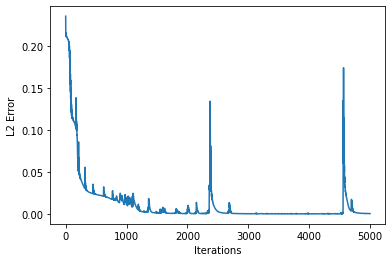

In [ ]:
#Training Loop
optimizer = torch.optim.Adam(npde_net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.9)

it=0
epochs = 5000
loss_list = []

start_time = time.time()
while it < epochs :
    optimizer.zero_grad()

    initial_loss = reconstruction(X_i, Y_i)
    boundary_loss = boundary(X_b)
    domain_loss = pde(X_f)

    loss = initial_loss + boundary_loss + domain_loss   
    loss_list.append(loss.item())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    it += 1

    print('It: %d, Init: %.3e, Bound: %.3e, Domain: %.3e' % (it, initial_loss.item(), boundary_loss.item(), domain_loss.item()))


train_time = time.time() - start_time
plt.plot(loss_list)
plt.xlabel('Iterations')
plt.ylabel('L2 Error')

In [ ]:
#Getting the trained output. 
if default_device == 'cpu':
    with torch.no_grad():
        u_pred = npde_net(torch_tensor_grad(X_star)).detach().numpy()

else : 
    with torch.no_grad():
        u_pred = npde_net(torch_tensor_grad(X_star)).cpu().detach().numpy()
        
l2_error = np.mean((u_actual - u_pred)**2)

print('Training Time: %d seconds, L2 Error: %.3e' % (train_time, l2_error))

u_pred = u_pred.reshape(len(u), grid_length, grid_length)

Training Time: 1559 seconds, L2 Error: 1.575e-02


In [ ]:
!pip install celluloid
from celluloid import Camera
from IPython.display import HTML

def animate(data):
  fig = plt.figure()
  camera = Camera(fig)
  for ii in range(len(data)):
      plt.imshow(data[ii])
      camera.snap()
  animation = camera.animate()

  return animation


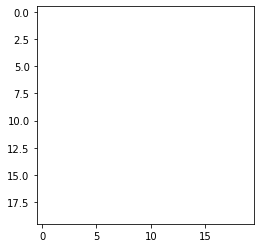

In [ ]:
animation = animate(u)
HTML(animation.to_html5_video())


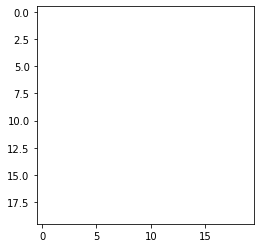

In [ ]:
animation = animate(u_pred)
HTML(animation.to_html5_video())

In [ ]:
from matplotlib import cm
from matplotlib import animation

def animation_plot(name, data):
    wave_name = name
    u_field = data
    xx, yy = np.meshgrid(x,y)


    def update_plot(frame_number, u_field, plot):
        plot[0].remove()
        plot[0] = ax.plot_surface(xx, yy, u_field[frame_number], cmap=cm.coolwarm, linewidth=2, antialiased=False)
        
        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    plot = [ax.plot_surface(xx, yy, u_field[0], cmap=cm.coolwarm, linewidth=2, antialiased=False)]
    # ax.set_xlim3d(-1.0, 1.0)
    # ax.set_ylim3d(-1.0, 1.0)
    # ax.set_zlim3d(-0.15, 1)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("U")
    ax.set_title(wave_name)

    # ax.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    # ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])

    #plt.tight_layout()
    ax.view_init(elev=30., azim=-110)


    fps = 10 # frame per sec
    frn = len(u_field) # frame number of the animation

    anim = animation.FuncAnimation(fig, update_plot, frn, fargs=(u_field, plot), interval=1000/fps)
    return anim

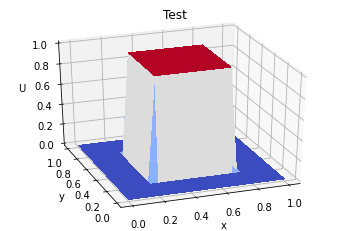

In [ ]:
animate = animation_plot('Test', u)
HTML(animate.to_html5_video())

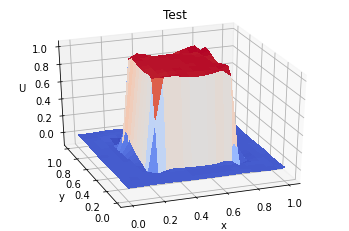

In [ ]:
animate = animation_plot('Test', u_pred)
HTML(animate.to_html5_video())